# 3.4 Concise Implementation of Linear Regression

## 1. How would you need to change the learning rate if you replace the aggregate loss over the minibatch with an average over the loss on the minibatch?

To increase the learning rate, because the loss is smaller and so that the gradient is smaller, to avoid the update being too small, we need to increase the learning rate.

## 2. Review the framework documentation to see which loss functions are provided. In particular, replace the squared loss with Huber's robust loss function. That is, use the loss function $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \textrm{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \textrm{ otherwise}\end{cases}$$

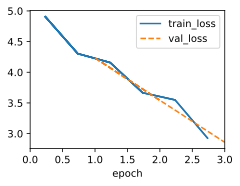

In [42]:
import numpy as np
import torch
import torch.nn as nn
from d2l import torch as d2l

#----- Define the Model(Net, Loss, Optimizer) -----#
class LinearRegression(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)  # only output dimension is needed
        # initialize weights and bias
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)
    
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y):
        '''Huber's robust loss function'''
        delta = 1
        # only apply to scalar output
        loss = torch.where(torch.abs(y_hat - y) < delta,  # condition
                           (y_hat - y) ** 2 / (2*delta),  # true clause(when condition is satified)
                           torch.abs(y_hat - y) - 0.5 * delta)  # false clause
        return loss.mean()
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)
#----- Train the Model -----#
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

## 3. How do you access the gradient of the weights of the model?

We can modify the Trainer class in d2l lib to see the gradient

In [43]:
#----- Define the Trainer -----#
class Trainer(d2l.HyperParameters):
    """The base class for training models with data.

    Defined in :numref:`subsec_oo-design-models`"""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
            break

    def prepare_batch(self, batch):
        """Defined in :numref:`sec_linear_scratch`"""
        return batch

    def fit_epoch(self):
        """Defined in :numref:`sec_linear_scratch`"""
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            print("before zero_grad: ", self.model.net.weight.grad)
            self.optim.zero_grad()
            print("after zero_grad: ", self.model.net.weight.grad)
            with torch.no_grad():
                loss.backward()
                print("after backward: ", self.model.net.weight.grad)
                return
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
#----- Train the Model -----#
model = d2l.LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

before zero_grad:  None
after zero_grad:  None
after backward:  tensor([[-4.1878,  8.6351]])


Also, one can access the gradient of the bias of the model through similar way.

## 4. What is the effect on the solution if you change the learning rate and the number of epochs? Does it keep on improving?

The learning rate will affect the rate of update. The larger the learning rate is, the more violently the model will update, which means increased possibility of fluctuating. With smaller learning rate, the model will update more slowly, meaning you need more epochs(more time) to train the model.
The number of epochs indicates the times you train the model on the training set. If this number is too small, the model may not be trained sufficiently. But if this number is too large, the model may overfit and its generality may decline.

## 5. How does the solution change as you vary the amount of data generated?
1. Plot the estimation error for $\hat{\mathbf{w}} - \mathbf{w}$ and $\hat{b} - b$ as a function of the amount of data. Hint: increase the amount of data logarithmically rather than linearly, i.e., 5, 10, 20, 50, ..., 10,000 rather than 1000, 2000, ..., 10,000.
2. Why is the suggestion in the hint appropriate?

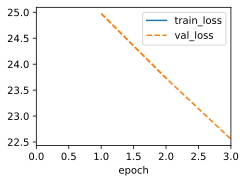

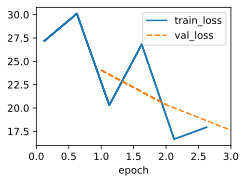

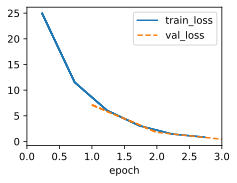

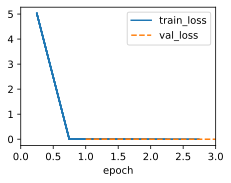

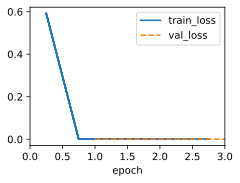

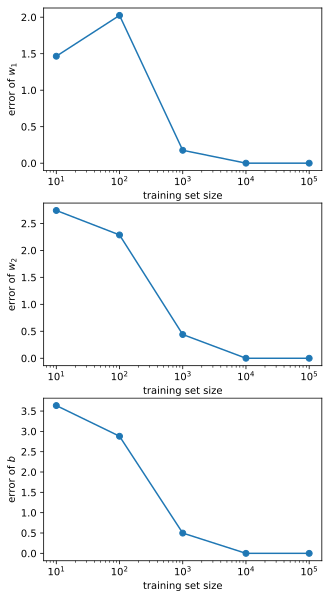

In [44]:
torch.manual_seed(0)
np.random.seed(0)
#----- Logarithmically increase data amount -----#
import matplotlib.pyplot as plt
error_w = [[], []]
error_b = []
for i in range(5):
    # training set sample number: 5**(i+1)
    num_train = 10 ** (i+1)
    # train the model
    model = d2l.LinearRegression(lr=0.01)
    data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2, num_train=num_train)
    trainer = d2l.Trainer(max_epochs=3)
    trainer.fit(model, data)
    # save the estimation error of w and b
    w, b = model.get_w_b()
    w = w.reshape(data.w.shape)
    error_w[0].append(np.abs(data.w[0].item() - w[0].item()))
    error_w[1].append(np.abs(data.w[1].item() - w[1].item()))
    error_b.append(np.abs(data.b - b.item()))
# plot the estimation error of w and b
x = [10**(i+1) for i in range(5)]
fig, ax = plt.subplots(3, 1, figsize=(5, 10))
ax[0].plot(x, error_w[0], '-o')
ax[0].set_xlabel('training set size')
ax[0].set_ylabel('error of $w_1$')
ax[0].set_xscale('log')
ax[1].plot(x, error_w[1], '-o')
ax[1].set_xlabel('training set size')
ax[1].set_ylabel('error of $w_2$')
ax[1].set_xscale('log')
ax[2].plot(x, error_b, '-o')
ax[2].set_xlabel('training set size')
ax[2].set_ylabel('error of $b$')
ax[2].set_xscale('log')
plt.show()

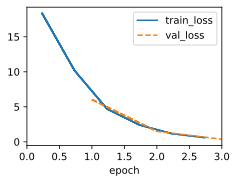

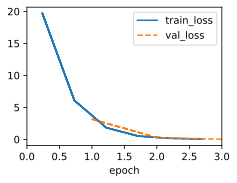

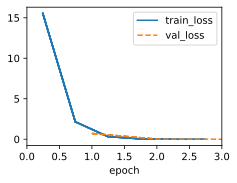

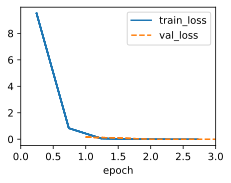

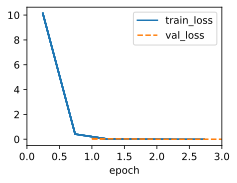

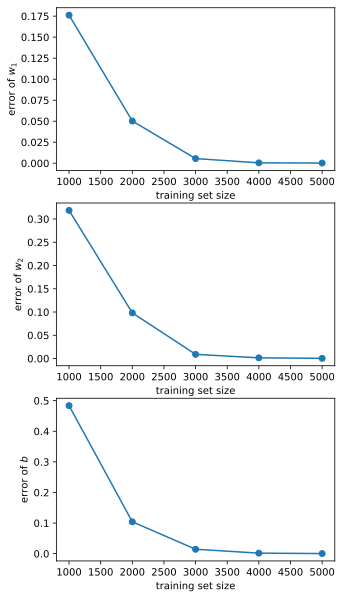

In [45]:
#----- Linearly increase data amount -----#
import matplotlib.pyplot as plt
error_w = [[], []]
error_b = []
for i in range(5):
    # training set sample number: 5**(i+1)
    num_train = 1000 * (i+1)
    # train the model
    model = d2l.LinearRegression(lr=0.01)
    data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2, num_train=num_train)
    trainer = d2l.Trainer(max_epochs=3)
    trainer.fit(model, data)
    # save the estimation error of w and b
    w, b = model.get_w_b()
    w = w.reshape(data.w.shape)
    error_w[0].append(np.abs(data.w[0].item() - w[0].item()))
    error_w[1].append(np.abs(data.w[1].item() - w[1].item()))
    error_b.append(np.abs(data.b - b.item()))
# plot the estimation error of w and b
x = [1000*(i+1) for i in range(5)]
fig, ax = plt.subplots(3, 1, figsize=(5, 10))
ax[0].plot(x, error_w[0], '-o')
ax[0].set_xlabel('training set size')
ax[0].set_ylabel('error of $w_1$')
ax[1].plot(x, error_w[1], '-o')
ax[1].set_xlabel('training set size')
ax[1].set_ylabel('error of $w_2$')
ax[2].plot(x, error_b, '-o')
ax[2].set_xlabel('training set size')
ax[2].set_ylabel('error of $b$')
plt.show()

2. didn't see something special in logarithmically increasing way.